# Query Fee Claim Frequency and Magnitude Study

Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft,fftfreq

import model.parts.utils as utils

%matplotlib inline

In [2]:
def load_all_events_to_pandas_df(path, agent_event_path = None):
    # make them ordered by blockNumber and logindex
    # squish them because time between doesn't matter
    # **but they have to be interleaved between all event types.
    # reset index
    # break back out to distinct types
    # use block number, resolve conflicts with log index.
    all_events = pd.read_csv(f'{path}')

    if agent_event_path:
        all_events = pd.concat([all_events, pd.read_csv(agent_event_path)])

    all_events.reset_index(inplace=True)
    all_events.sort_values(['blockNumber', 'logIndex'], ascending=[True, True])
    all_events = all_events.rename(columns={'index': 'timestep'})
    
    # start with timestep 1.
    all_events['timestep'] = all_events['timestep'] + 1
    all_events.set_index('timestep', inplace=True, drop=False)
    return all_events

In [3]:
event_path = 'multiple_indexer/allindexer/allEvents.csv'

In [4]:
all_events_df = load_all_events_to_pandas_df(event_path)

C:\Users\mbarl\AppData\Local\Temp\ipykernel_4380\3943526676.py:8: DtypeWarning: Columns (0,6,9,10,11,12,13,14,15,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  all_events = pd.read_csv(f'{path}')


In [5]:
all_events_df.head()

,timestep,allocationID,blockNumber,epoch,id,indexer,logIndex,subgraphDeploymentID,tokens,type,...,from,rebateFees,delegator,shares,eventTime,until,indexingRewardCut,queryFeeCut,delegationFees,amount
timestep,,,,,,,,,,,,,,,,,,,,,
1,1,0xfbc5e8d942122bbad88f4868500356bc59164c8f,11474062,4.0,0xc037be198c842da82ef12c8bc6003e5c8684c1bfa274...,0xa959b5afe73c6faa803541b5c4edc0492dfda294,290,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,8000000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0x566bb471e1dec5d97985981b86503dd4be561479,11474065,4.0,0x1fd0fa14121d920bde44890feece6cbb592f064e8ed8...,0xa959b5afe73c6faa803541b5c4edc0492dfda294,297,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,8000000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0x4dede41c1cfbaaf990e736039a0ebe1001073f7c,11474097,4.0,0xf470c9f4df65a955622ddb8813334d19f5bb7abf55ee...,0x62a0bd1d110ff4e5b793119e95fc07c9d1fc8c4a,201,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,50000000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0xd60a65b8f4b5083a9b8a26775bbf1da7f53c7eae,11474187,4.0,0x5dcc3cc5d2e6fb45fa4a020e77bef9137aa44de13c10...,0x62a0bd1d110ff4e5b793119e95fc07c9d1fc8c4a,50,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,70000000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,0x7901c76b0ce0db5b3f3e96535b70a7550adcb423,11474266,4.0,0x2a612e88f706256179474aa3b1c09a0c884a2257e911...,0x62a0bd1d110ff4e5b793119e95fc07c9d1fc8c4a,159,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,500000000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
len(all_events_df)

107861

In [7]:
all_events_df.columns

Index(['timestep', 'allocationID', 'blockNumber', 'epoch', 'id', 'indexer',
       'logIndex', 'subgraphDeploymentID', 'tokens', 'type', 'isDelegator',
       'sender', 'curationFees', 'from', 'rebateFees', 'delegator', 'shares',
       'eventTime', 'until', 'indexingRewardCut', 'queryFeeCut',
       'delegationFees', 'amount'],
      dtype='object')

In [8]:
all_events_df.type.unique()

array(['allocationCreateds', 'allocationCloseds', 'allocationCollecteds',
       'stakeDelegateds', 'stakeDelegatedLockeds',
       'stakeDelegatedWithdrawns', 'delegationParametersUpdateds',
       'rebateClaimeds', 'rewardsAssigneds', 'stakeDepositeds'],
      dtype=object)

In [9]:
all_events_df['curationFees'] = all_events_df['curationFees'].astype(float)
all_events_df['curationFees'] = all_events_df['curationFees']/10e18

### Query Fee Magnitude

In [10]:
all_events_df.curationFees.describe()

count    9485.000000
mean        0.275986
std         1.762144
min         0.000000
25%         0.002002
50%         0.022756
75%         0.101001
max       117.671150
Name: curationFees, dtype: float64

### Query Fee Frequency
#### Allocation Length

In [11]:
all_events_df[all_events_df['type']=='allocationCreateds']

,timestep,allocationID,blockNumber,epoch,id,indexer,logIndex,subgraphDeploymentID,tokens,type,...,from,rebateFees,delegator,shares,eventTime,until,indexingRewardCut,queryFeeCut,delegationFees,amount
timestep,,,,,,,,,,,,,,,,,,,,,
1,1,0xfbc5e8d942122bbad88f4868500356bc59164c8f,11474062,4.0,0xc037be198c842da82ef12c8bc6003e5c8684c1bfa274...,0xa959b5afe73c6faa803541b5c4edc0492dfda294,290,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,8000000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0x566bb471e1dec5d97985981b86503dd4be561479,11474065,4.0,0x1fd0fa14121d920bde44890feece6cbb592f064e8ed8...,0xa959b5afe73c6faa803541b5c4edc0492dfda294,297,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,8000000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0x4dede41c1cfbaaf990e736039a0ebe1001073f7c,11474097,4.0,0xf470c9f4df65a955622ddb8813334d19f5bb7abf55ee...,0x62a0bd1d110ff4e5b793119e95fc07c9d1fc8c4a,201,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,50000000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0xd60a65b8f4b5083a9b8a26775bbf1da7f53c7eae,11474187,4.0,0x5dcc3cc5d2e6fb45fa4a020e77bef9137aa44de13c10...,0x62a0bd1d110ff4e5b793119e95fc07c9d1fc8c4a,50,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,70000000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,0x7901c76b0ce0db5b3f3e96535b70a7550adcb423,11474266,4.0,0x2a612e88f706256179474aa3b1c09a0c884a2257e911...,0x62a0bd1d110ff4e5b793119e95fc07c9d1fc8c4a,159,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,500000000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17017,17017,0xc7658b101fca10bdebdb1ca5ae99dfecd94f2012,14080360,396.0,0xa49dfc29d63fb7f7b3c25779a3f9b41a16fbf1224d26...,0x07051463ca2414f716d37da8cdbcdb5abe4cc239,170,0x2aaeb45afa62af1cc8f6d61decd5249429e0aaed6799...,2163000000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17018,17018,0x99f339e83469c70ecf1f65f63b29b3f6d336c8de,14081831,396.0,0xc4e702ed0c15a870405f8f3c9739c6221e2ea8115bc7...,0x6879bbfcff0e54e62b899681ea52e74bd9b29fe4,192,0x7cf8f2026b1f49a36f29293fb9545ce31ac3f71c4000...,2050767000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17019,17019,0xe5ec8775027c7d215636ade54a0b5df0683b4acb,14082697,396.0,0x9130ec5eeab6aef6c611671c04707fd530039fe86b99...,0x6ac85b9d834b51b14a7b0ed849bb5199e04c05c5,88,0x014e8a3184d5fad198123419a7b54d5f7c9f8a981116...,1889658000000000000000000,allocationCreateds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
all_events_df[all_events_df['type']=='allocationCollecteds']

,timestep,allocationID,blockNumber,epoch,id,indexer,logIndex,subgraphDeploymentID,tokens,type,...,from,rebateFees,delegator,shares,eventTime,until,indexingRewardCut,queryFeeCut,delegationFees,amount
timestep,,,,,,,,,,,,,,,,,,,,,
33174,33174,0x69b8a4c937638654c6d14340602d94b9627d4c19,11515164,10.0,0x4bd3585834cb6bf0477d9e45f49d075d9cb50e780107...,0x362717d3fa1bfe457535b9b716f450b95a858217,306,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,1625600000000000000,allocationCollecteds,...,0x9fd8ac559219d4dd463193d1fb0433f7844f730f,1448409600000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33175,33175,0x322fd9ad3b2f0498a4da371bdc499224b70dd3b8,11515417,10.0,0xff642404c02f51e4530e00e3450e802edb738aeb50a5...,0xd11e05240a50e2eedb03e72d4c9c6465bc05f2a4,318,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,162645000000000000,allocationCollecteds,...,0x9fd8ac559219d4dd463193d1fb0433f7844f730f,144916695000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33176,33176,0x322fd9ad3b2f0498a4da371bdc499224b70dd3b8,11515434,10.0,0x019bf5e9219ca09d3e981099f396859bc1bd8cf9d8d8...,0xd11e05240a50e2eedb03e72d4c9c6465bc05f2a4,161,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,162645000000000000,allocationCollecteds,...,0x9fd8ac559219d4dd463193d1fb0433f7844f730f,144916695000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33177,33177,0x02353e9c1d14fe8e3eccf316fe6dde4aaf43cf58,11515434,10.0,0x207a27ec6f037f62d03e9a9246a5a2b5216c4b55efba...,0xc430be492ddeb6e761dbbd0e08bafe99f5064d90,167,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,3545973625650624567,allocationCollecteds,...,0x9fd8ac559219d4dd463193d1fb0433f7844f730f,3159462500454706490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33178,33178,0x322fd9ad3b2f0498a4da371bdc499224b70dd3b8,11515434,10.0,0x4990bb5078ab860f857a3e6fab2a800e8cdb60d043a4...,0xd11e05240a50e2eedb03e72d4c9c6465bc05f2a4,149,0x31edcacc9a53bc8ab4be2eeb0d873409da4c4228cb2d...,162645000000000000,allocationCollecteds,...,0x9fd8ac559219d4dd463193d1fb0433f7844f730f,144916695000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42654,42654,0x0ae2c3f6d8dbf171a8965b8798f2d4cd78b75dcb,14066148,394.0,0x4ec8638d3ae35e675160845d201ae38328daa27dad95...,0x427f071e335bfa32241bbfa7f240f24a8a46f292,91,0x143db715c25f1e97631fd370a1db89108baace5ae713...,330000000000000,allocationCollecteds,...,0x4a53cf3b3eda545dc61dee0ca21ea8996c94385f,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42655,42655,0x1987f6c234cd7d0f8c2efe4fa4c731879ee7e13e,14066152,394.0,0x92815cc98b384da7f60c3998c54c342378c389c6d7e7...,0x427f071e335bfa32241bbfa7f240f24a8a46f292,57,0x143db715c25f1e97631fd370a1db89108baace5ae713...,670000000000000,allocationCollecteds,...,0x4a53cf3b3eda545dc61dee0ca21ea8996c94385f,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42656,42656,0x8771efb8269b17954f8b010ad597040e7e5cfa68,14066155,394.0,0xef13e3d56382d3d2611edef9c56194edaea8a8e18c67...,0x427f071e335bfa32241bbfa7f240f24a8a46f292,24,0x3205ac49a08abcc864f7be007ef031d89d9d738b7f45...,1670000000000000,allocationCollecteds,...,0x4a53cf3b3eda545dc61dee0ca21ea8996c94385f,1487970000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
collected_ids = all_events_df[all_events_df['type']=='allocationCollecteds']['allocationID']

In [14]:
created_df = all_events_df[all_events_df['type']=='allocationCreateds']

In [15]:
epoch_list =[] 
for id in collected_ids:
    matched_record = created_df[created_df['allocationID']==id]
    epoch_list.append(matched_record.epoch.values)

In [16]:
epoch_list

[array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([8.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([8.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([9.]),
 array([10.]),
 array([10.]),
 array([9.]),
 array([9.]),
 array([9.]),
 array([10.]),
 array([9.]),
 array([10.]),
 array([8.]),
 array([9.]),
 array([9.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([8.]),
 array([10.]),
 arr

In [17]:
len(epoch_list)

9485

In [18]:
epoch_df = pd.DataFrame(epoch_list,columns=['epoch'])

In [19]:
epoch_df

,epoch
0,9.0
1,9.0
2,9.0
3,9.0
4,9.0
...,...
9480,325.0
9481,351.0
9482,365.0
9483,368.0


In [20]:
epoch_df['time_delta'] =all_events_df[all_events_df['type']=='allocationCollecteds'].epoch.values - epoch_df.epoch.values

In [21]:
epoch_df

,epoch,time_delta
0,9.0,1.0
1,9.0,1.0
2,9.0,1.0
3,9.0,1.0
4,9.0,1.0
...,...,...
9480,325.0,69.0
9481,351.0,43.0
9482,365.0,29.0
9483,368.0,27.0


In [22]:
epoch_df.time_delta.describe()

count    9481.000000
mean       10.156524
std        10.914463
min         0.000000
25%         2.000000
50%         7.000000
75%        14.000000
max       169.000000
Name: time_delta, dtype: float64

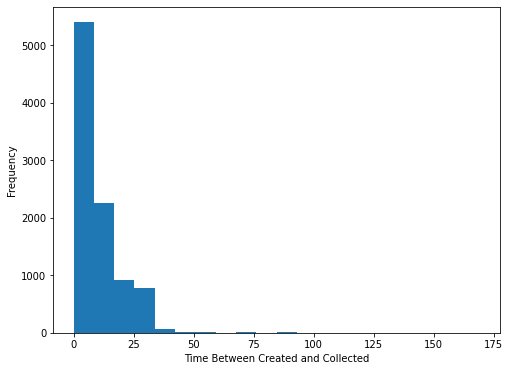

In [29]:
plt.figure(figsize=(8,6))
plt.hist(epoch_df.time_delta,bins=20)
plt.xlabel('Time Between Created and Collected')
plt.ylabel('Frequency')
plt.show()

In [34]:
epoch_freq = fft(np.array(epoch_df.time_delta[9000:]))

In [35]:
epoch_freq

array([ 1.40210000e+04   -0.j        ,  1.36570463e+03+1996.47966876j,
        6.21540311e+01 +772.91045751j,  1.59251179e+03 +959.67083074j,
        1.24642528e+03+1964.71762392j,  4.68678548e+02+1288.75841136j,
       -4.96937799e+01 +614.42436234j, -2.74013215e+02 +583.14007009j,
       -2.16579758e+02+2039.03927122j, -1.33660330e+03+1596.02524176j,
       -5.97391732e+02 -706.20442998j, -1.33655217e+03  +82.94054971j,
       -1.26058608e+03 +222.25684108j, -1.75163752e+03 +270.80937726j,
       -5.24710842e+02 -602.07262364j, -4.10124958e+02 -758.65876326j,
       -9.31727556e+02 -654.72333331j,  1.04713793e+02 -878.35153044j,
        5.48926592e+02 -764.64594531j,  6.38677966e+02-1093.3946399j ,
        3.06988663e+02 -778.76459002j,  4.54857913e+02 -539.67333741j,
        1.29604253e+03 +506.87690081j,  5.64455391e+02 +408.84943935j,
        1.10393869e+03 -628.59098259j,  3.43079064e+02 +627.11110522j,
       -8.30521112e+00 +587.85842684j,  7.95811434e+02 +390.69883485j,
      

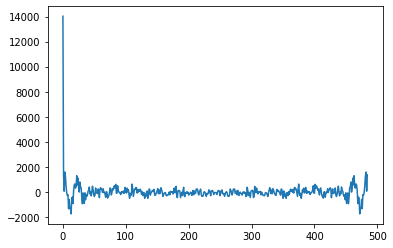

In [36]:
plt.plot(epoch_freq.real)
plt.show()

In [27]:
allocation_created = all_events_df[all_events_df['type']=='allocationCreateds']

In [28]:
set(allocation_created['allocationID']).intersection(set(collected_query['allocationID']))

NameError: name 'collected_query' is not defined

In [ ]:
event_type = all_events_df.groupby('type')

In [ ]:
allocation_created_match = allocation_created[allocation_created['allocationID']==collected_query['allocationID']]

In [ ]:
set(all_events_df['allocationID']).intersection(set(collected_query['allocationID']))

In [ ]:
allocation_created.where(all_events_df.allocationID.values==collected_query.allocationID.values).notna()

In [ ]:
alloc_start = all_events_df[all_events_df['type']=='allocationCreateds']
for i in collected_query:
    alloc_start = alloc_start[alloc_start['allocationID']==i]
    print(alloc_start)
# alloc_start = al
# for i in collected_query:
#     alloc_start = alloc_start.join() all_events_df[all_events_df['type']=='allocationCreateds'] and all_events_df['allocationID']==i]

In [ ]:
alloc_start